In [1]:
%pylab inline
from __future__ import division
from scipy import stats
from numpy import exp
import numpy as np
import pylab as pl
import pandas as pd
import math
import time
from copy import deepcopy as dc
pl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Random_Grid_Search:
    t_n = 500 #抽样量
    c_n = 50 #保留参数量
    threshold = 1e-6 #循环停止阈值
    repetes = 1 #重复次数
    orig_points = [] #初始化边界点
    def __init__(self,s): #初始化实例参数
        self.s = np.array(s)  #待拟合曲线
        self.s_len = len(s)
        self.para_range = [[1e-6,0.1],[1e-3,1],[sum(s),5*sum(s)]]  #参数范围
        self.p_range = [[1e-6,0.1],[1e-3,1],[sum(s),5*sum(s)]]  #用于产生边界节点的参数范围 
    
    def genera_orig(self): #递归产生边界点
        if len(self.p_range) == 0:
            return
        else:  
            pa = self.p_range[-1]
            if self.orig_points == []:
                self.orig_points = [[pa[0]],[pa[1]]]  #初始化,排除orig_points为空的情形
            else:
                self.orig_points = [[pa[0]]+x for x in self.orig_points]+[[pa[1]]+x for x in self.orig_points]  #二分裂
            self.p_range.pop()
            return self.genera_orig()
    
    def sample(self,c_range): #抽样参数点
        p_list = []
        for pa in c_range:
            if isinstance(pa[0],float):
                x = (pa[1]-pa[0])*np.random.random(self.t_n) + pa[0]
            else:
                x = np.random.randint(low=pa[0],high=pa[1]+1,size=self.t_n)
            p_list.append(x)

        p_list = np.array(p_list).T
        return p_list.tolist()
    
    def f(self,params): #扩散函数
        diffu_cont = np.zeros(self.s_len)
        t_list = np.arange(1,self.s_len+1)
        a = np.array([1 - np.exp(-(params[0]+params[1])*t) for t in t_list])
        b = np.array([1 + params[1]/params[0]*np.exp(-(params[0]+params[1])*t) for t in t_list])
        diffu_cont = params[2]*a/b

        adopt_cont = np.zeros_like(diffu_cont)
        adopt_cont[0] = diffu_cont[0]
        for t in xrange(1,self.s_len):
            adopt_cont[t] = diffu_cont[t] - diffu_cont[t-1]

        return adopt_cont

    def mse(self,params):  #定义适应度函数（mse）
        a = self.f(params)
        tse = np.square(self.s-a)
        return np.mean(tse) #均方误
    
    def r2(self,params):
        a = np.array(self.f(params))
        tse = np.sum(np.square(self.s-a))
        mean_y = np.mean(self.s)
        ssl = np.sum(np.square(self.s-mean_y))
        return (ssl-tse)/ssl
    
    def optima_search(self):
        solution_cont = []
        self.genera_orig()
        
        for i in xrange(self.repetes):
            c_range = dc(self.para_range)
            samp = self.sample(c_range)
            solution = sorted([self.mse(x)]+x for x in samp+self.orig_points)[:self.c_n]
            u = 1
            while 1:
                params_min = np.min(np.array(solution),0) #最小值
                params_max = np.max(np.array(solution),0) #最大值
                c_range = [[params_min[j+1],params_max[j+1]] for j in range(len(c_range))] #重新定界
                samp = self.sample(c_range)
                solution = sorted([[self.mse(x)]+x for x in samp]+solution)[:self.c_n]
                r = sorted([x[0] for x in solution])
                v = (r[-1]-r[0])/r[0]
                if v < self.threshold:
                    print 'Searching ends in %s runs'%u
                    break
                
                if u > 100:
                    print 'Searching ends in 100 runs'
                    break
                
                u += 1

            solution_cont.append(solution[0])

        solution = np.array(solution_cont)
        estimates = np.median(solution,axis=0)[1:]
        R2 = self.r2(estimates)
        return estimates,R2,solution
    
    def draw_curve(self,estms):
        f1 = self.f(estms)
        fig = pl.figure(figsize=(12,6))
        ax = fig.add_subplot(1,1,1)
        ax.plot(np.arange(1,self.s_len+1),self.s,'bo',label=r'$actual$')
        ax.plot(np.arange(1,self.s_len+1),f1,'r-',linewidth = 1.2,label=r'$fitted$')
        ax.set_title(r'Fitted and actual curve',fontsize=12)
        ax.set_xlabel(r'Time',fontsize=15)
        ax.set_ylabel(r'Sales',fontsize=15)
        ax.set_xlim([1,self.s_len])
        ax.legend(loc = 'best',fontsize=15)
        ax.grid(True)      

In [3]:
data_set = {'room air conditioners':(np.arange(1949,1962),[96,195,238,380,1045,1230,1267,1828,1586,1673,1800,1580,1500]),
            'color televisions':(np.arange(1963,1971),[747,1480,2646,5118,5777,5982,5962,4631]),
            'clothers dryers':(np.arange(1949,1962),[106,319,492,635,737,890,1397,1523,1294,1240,1425,1260,1236]),
            'ultrasound':(np.arange(1965,1979),[5,3,2,5,7,12,6,16,16,28,28,21,13,6]),
            'mammography':(np.arange(1965,1979),[2,2,2,3,4,9,7,16,23,24,15,6,5,1]),
            'foreign language':(np.arange(1952,1964),[1.25,0.77,0.86,0.48,1.34,3.56,3.36,6.24,5.95,6.24,4.89,0.25]),
            'accelerated program':(np.arange(1952,1964),[0.67,0.48,2.11,0.29,2.59,2.21,16.80,11.04,14.40,6.43,6.15,1.15])}
china_set = {'color tv':(np.arange(1997,2013),[2.6,1.2,2.11,3.79,3.6,7.33,7.18,5.29,8.42,5.68,6.57,5.49,6.48,5.42,10.72,5.15]),
             'mobile phone':(np.arange(1997,2013),[1.7,1.6,3.84,12.36,14.5,28.89,27.18,21.33,25.6,15.88,12.3,6.84,9.02,7.82,16.39,7.39]),
             }

In [4]:
for x in data_set.keys():
    time1 = time.clock()
    y = data_set[x][0]
    s = data_set[x][1]
    rgs = Random_Grid_Search(s)
    print '----------------------------------%s-----------------------------------'%x
    rgs.repetes = 1
    fit = rgs.optima_search()[:2] 
    p,q,m = fit[0]
    r2 = fit[1]
    print '    p:%.5f, q:%.5f, m:%d, R2:%.4f'%(p,q,m,r2)
    print '    Time elasped:%.3f s'%(time.clock()-time1)

----------------------------------color televisions-----------------------------------
Searching ends in 21 runs
    p:0.01847, q:0.61586, m:39658, R2:0.9695
    Time elasped:0.478 s
----------------------------------clothers dryers-----------------------------------
Searching ends in 19 runs
    p:0.01360, q:0.32669, m:16497, R2:0.9181
    Time elasped:0.686 s
----------------------------------accelerated program-----------------------------------
Searching ends in 23 runs
    p:0.00089, q:0.89853, m:66, R2:0.7938
    Time elasped:0.665 s
----------------------------------ultrasound-----------------------------------
Searching ends in 27 runs
    p:0.00177, q:0.58464, m:176, R2:0.8342
    Time elasped:0.943 s
----------------------------------foreign language-----------------------------------
Searching ends in 25 runs
    p:0.00189, q:0.70569, m:37, R2:0.8410
    Time elasped:0.777 s
----------------------------------room air conditioners-----------------------------------
Searching 

In [90]:
class RGS_Discrete(Random_Grid_Search):
    def f(self,params):
        adopt_cont = [params[0]*params[2]]
        i = 2
        while i <= self.s_len:
            x = (params[2]-sum(adopt_cont))*(params[0]+params[1]*sum(adopt_cont)/params[2])
            adopt_cont.append(int(x))
            i += 1
        return np.array(adopt_cont)

In [81]:
s = data_set['room air conditioners'][1]
rgs = RGS_Discrete(s)

In [84]:
time1 = time.clock()
rgs.threshold = 1e-3
estimate,r2 = rgs.optima_search()[:2]
print time.clock()-time1,'s'

2.311082 s


In [94]:
for x in data_set.keys():
    time1 = time.clock()
    y = data_set[x][0]
    s = data_set[x][1]
    rgs = RGS_Discrete(s)
    rgs.t_n = 500
    rgs.threshold = 1e-4
    print '----------------------------------%s-----------------------------------'%x
    rgs.repetes = 1
    fit = rgs.optima_search()[:2] 
    p,q,m = fit[0]
    r2 = fit[1]
    print '    p:%.5f, q:%.5f, m:%d, R2:%.4f'%(p,q,m,r2)
    print '    Time elasped:%.3f s'%(time.clock()-time1)

----------------------------------color televisions-----------------------------------
Searching ends in 100 runs
    p:0.03291, q:0.63690, m:36781, R2:0.9499
    Time elasped:13.376 s
----------------------------------clothers dryers-----------------------------------
Searching ends in 100 runs
    p:0.01855, q:0.33177, m:15820, R2:0.9062
    Time elasped:20.725 s
----------------------------------accelerated program-----------------------------------
Searching ends in 19 runs
    p:0.01034, q:0.80661, m:73, R2:0.7636
    Time elasped:3.879 s
----------------------------------ultrasound-----------------------------------
Searching ends in 27 runs
    p:0.00685, q:0.61250, m:174, R2:0.8937
    Time elasped:6.923 s
----------------------------------foreign language-----------------------------------
Searching ends in 23 runs
    p:0.01782, q:0.57274, m:39, R2:0.8289
    Time elasped:4.855 s
----------------------------------room air conditioners-----------------------------------
Search

Searching ends in 19 runs
R2:0.886096069845


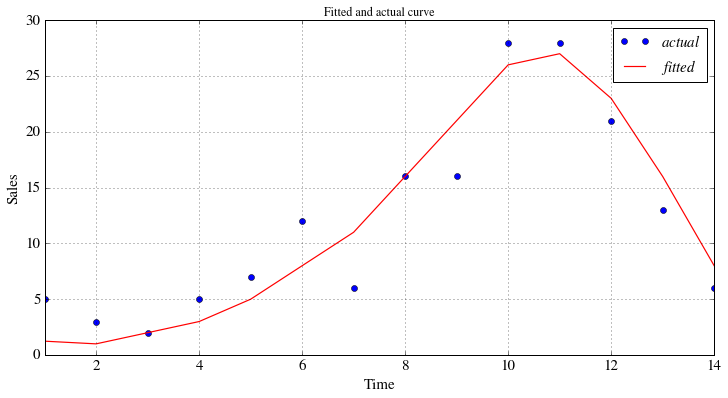

In [97]:
s = data_set['ultrasound'][1]
rgs = RGS_Discrete(s)
rgs.threshold = 1e-4
fit = rgs.optima_search()[:2]
print 'R2:%s'%fit[1]
rgs.draw_curve(fit[0])

Searching ends in 17 runs
R2:0.796905896712


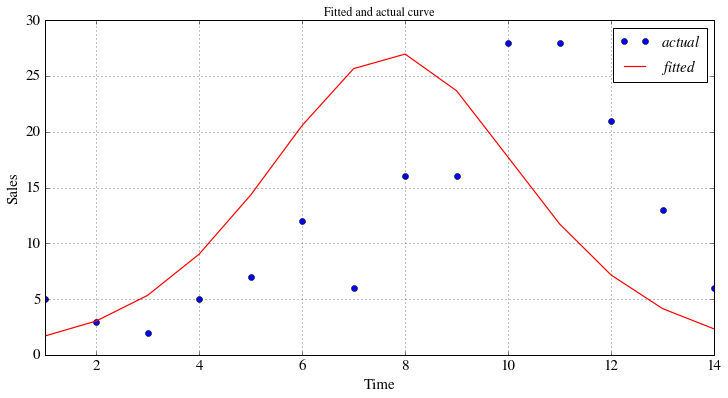

In [98]:
rgs_1 = Random_Grid_Search(s)
fit_1 = rgs_1.optima_search()[:2]
print 'R2:%s'%fit_1[1]
rgs_1.draw_curve(fit[0])